<div dir='rtl'>
<h1>پروژه چهارم</h1>
</div>

In [1]:
from __future__ import unicode_literals
from bidi.algorithm import get_display
from arabic_reshaper import reshape
import hazm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
TRAIN_PATH = 'data/train.csv'
TEST_PATH = 'data/test.csv'
STOP_WORDS_PATH = 'data/stopwords.txt'

In [3]:
train_df = pd.read_csv(TRAIN_PATH)
display(train_df)

,label,content
0,فناوری,گزارش های منتشر شده حاکی از آن است که کاربران ...
1,ورزشی,سوپر استار سینما و از قهرمانان سابق ووشو ــ کو...
2,حوادث,مدیرعامل شرکت عمران آب کیش از فوت یک نفر در آت...
3,فناوری,یک نوجوان انگلیسی به اتهام هک حساب‌های کاربری ...
4,سلامت,دانشمندان در جدیدترین مطالعات خود اثرات جدید و...
...,...,...
8995,حوادث,شانزدهم مهر امسال درپی تماس با مرکز فوریت‌های ...
8996,ورزشی,اتحادیه فوتبال ترینیداد و توباگو اعلام کرده تی...
8997,فرهنگی/هنری,اسامی 18 فیلم بخش مسابقه مستند ششمین دوره جشنو...
8998,حوادث,کامیونت حامل بار تخته‌های چوبی عصر دیروز چهارش...


In [4]:
label_counts = train_df['label'].value_counts()
label_counts = pd.DataFrame(label_counts)
label_counts = label_counts.reset_index()
label_counts.columns = ['label', 'count'] # type: ignore
display(label_counts)

,label,count
0,فناوری,1500
1,ورزشی,1500
2,حوادث,1500
3,سلامت,1500
4,سیاسی,1500
5,فرهنگی/هنری,1500


<div dir='rtl'>
<h2>فاز اول: پیش‌پردازش داده</h2>
</div>

In [5]:
class TextNormalizer:
    def __init__(self, remove_stopwords: bool = True, lemmatize: bool = True, stem: bool = False, normalize: bool = False):
        self.remove_stopwords: bool = remove_stopwords
        self.lemmatize: bool = lemmatize
        self.stem: bool = stem
        self.normalize: bool = normalize

        self.normalizer: hazm.Normalizer = hazm.Normalizer()
        self.lemmatizer: hazm.Lemmatizer = hazm.Lemmatizer()
        self.stemmer: hazm.Stemmer = hazm.Stemmer()
        stopwords = hazm.stopwords_list(STOP_WORDS_PATH)
        self.stopwords: set[str] = set(self._stemAndLemmatize(word) for word in stopwords)
        self.stopwords.update(['\n', '\r', ' ', '\xa0'])

    def _stemAndLemmatize(self, text: str) -> str:
        text.replace('\u200c', ' ')
        tokens = hazm.word_tokenize(text)
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        if self.stem:
            tokens = [self.stemmer.stem(token) for token in tokens]
        text = ' '.join(tokens)
        return text

    def normalize_text(self, text: str) -> str:
        if self.normalize:
            text = self.normalizer.normalize(text)
        tokens = hazm.word_tokenize(text)
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        if self.stem:
            tokens = [self.stemmer.stem(token) for token in tokens]
        if self.remove_stopwords:
            tokens = [token for token in tokens if token not in self.stopwords]
        text = ' '.join(tokens)
        return text

    def add_stopwords(self, *words: str):
        self.stopwords.update(self._stemAndLemmatize(word) for word in words)

In [6]:
normalizer = TextNormalizer()
def normalize(df: pd.DataFrame) -> pd.DataFrame:
    df['content'] = df['content'].apply(normalizer.normalize_text)
    return df

In [7]:
train_df = normalize(train_df)
display(train_df)

,label,content
0,فناوری,گزارش منتشر حاکی کاربر تلگرام مناطق جهان اروپا...
1,ورزشی,سوپر استار سینما قهرمان ووشو ــ کونگ‌فو حضور ش...
2,حوادث,مدیرعامل شرکت عمران آب کیش فوت آتش‌سوزی بازار ...
3,فناوری,نوجوان انگلیسی اتهام هک کاربر ایمیل تلفن مقام ...
4,سلامت,دانشمند مطالعات اثرات ویروس کرونا گوش کشف گزار...
...,...,...
8995,حوادث,شانزدهم مهر تماس مرکز فوریت پلیس 110 کرمان درگ...
8996,ورزشی,اتحادیه فوتبال ترینیداد توباگو تیم ملی کشور تا...
8997,فرهنگی/هنری,اسامی 18 فیلم مسابقه ششمین دوره جشنواره فیلم ک...
8998,حوادث,کامیونت حامل تخته چوب عصر چهارشنبه برخورد حفاظ...


In [8]:
def plot_most_common_words(texts: list[str], label: str, n: int = 5):
    words = []
    for text in texts:
        words.extend(hazm.word_tokenize(text))
    words = pd.Series(words)
    words_counts = words.value_counts()
    words_counts = pd.DataFrame(words_counts)
    words_counts = words_counts.reset_index()
    words_counts.columns = ['word', 'count'] # type: ignore
    words_counts = words_counts.head(n)
    persian_words = [get_display(reshape(word)) for word in words_counts['word']]
    plt.figure(figsize=(10, 5))
    plt.bar(persian_words, words_counts['count'])
    plt.xticks(rotation=45)
    plt.title(f'Most common words in {get_display(reshape(label))}')
    plt.show()

def plot_most_common_words_for_each_label(df: pd.DataFrame, n: int = 5):
    global label_counts
    for label in label_counts['label']: # type: ignore
        plot_most_common_words(df[df['label'] == label]['content'], label, n)

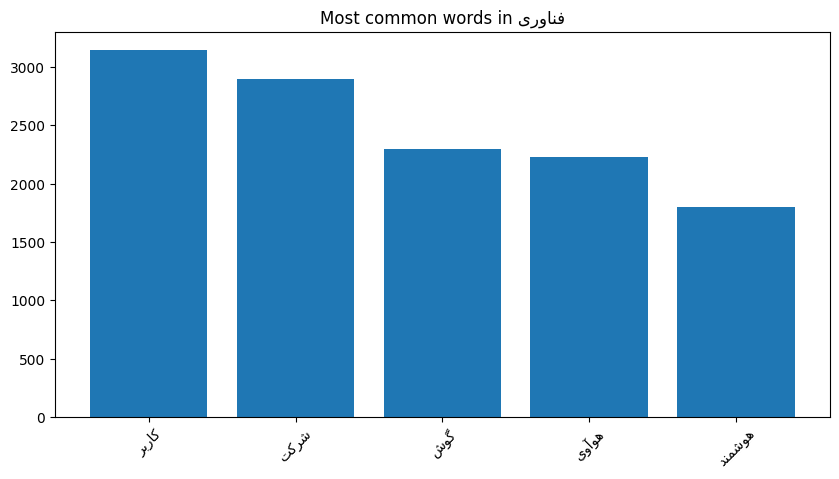

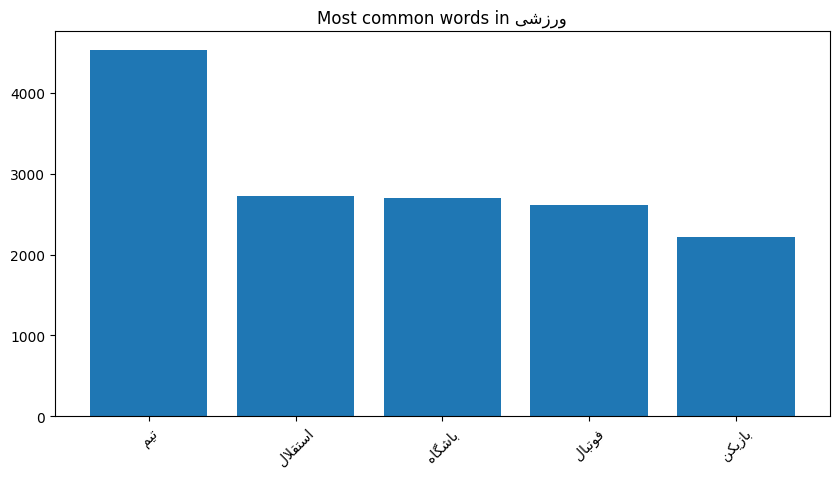

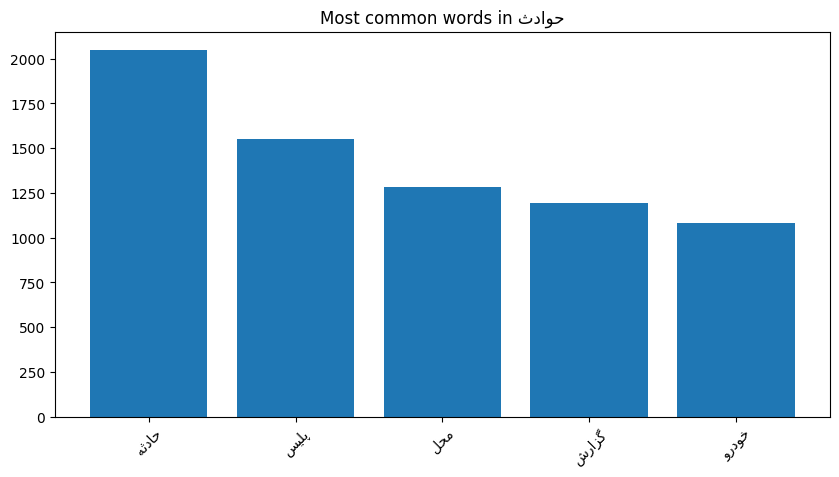

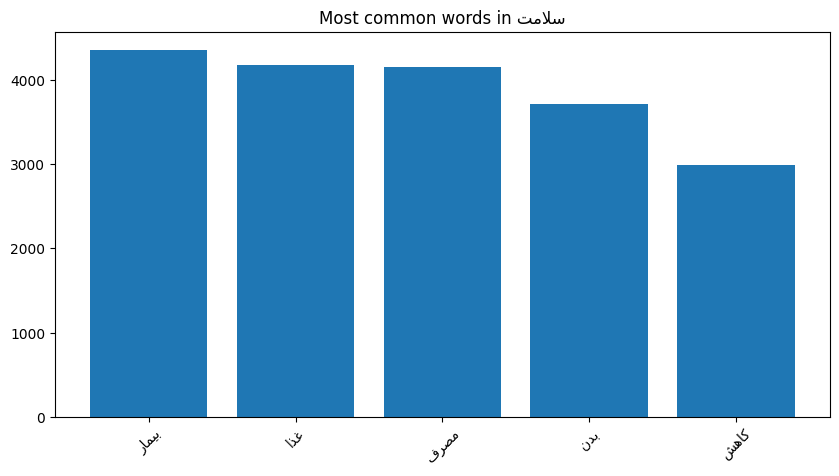

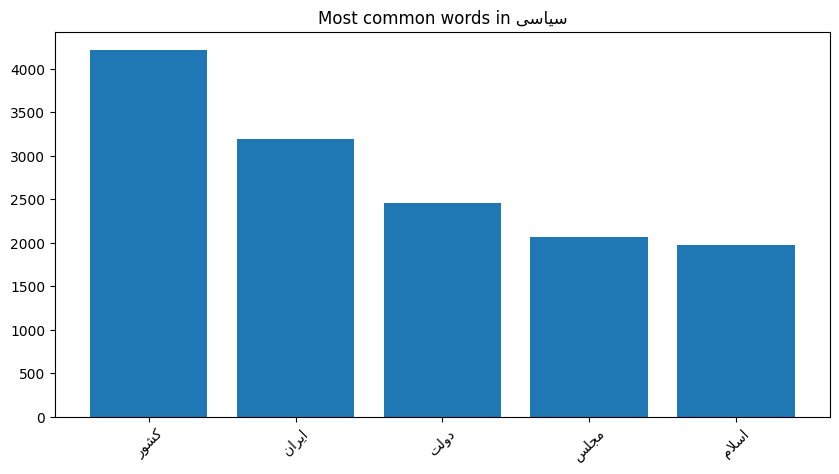

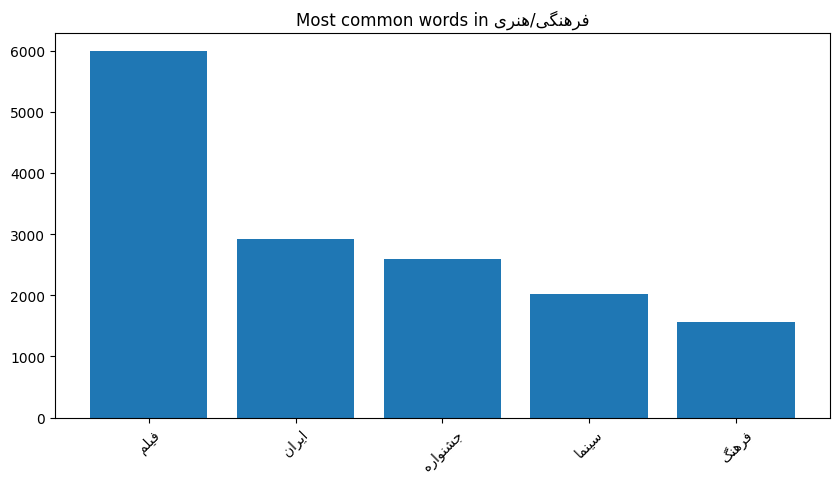

In [9]:
plot_most_common_words_for_each_label(train_df)

In [10]:
normalizer.add_stopwords("گوشی", "ایران", "اسلام")

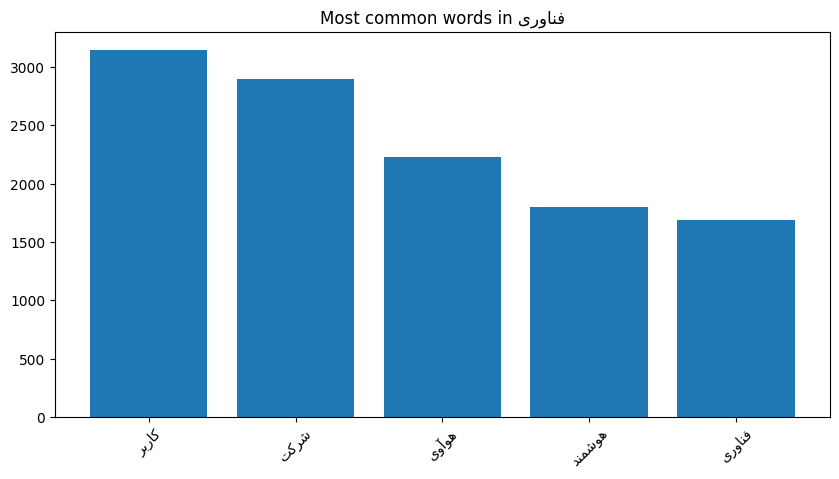

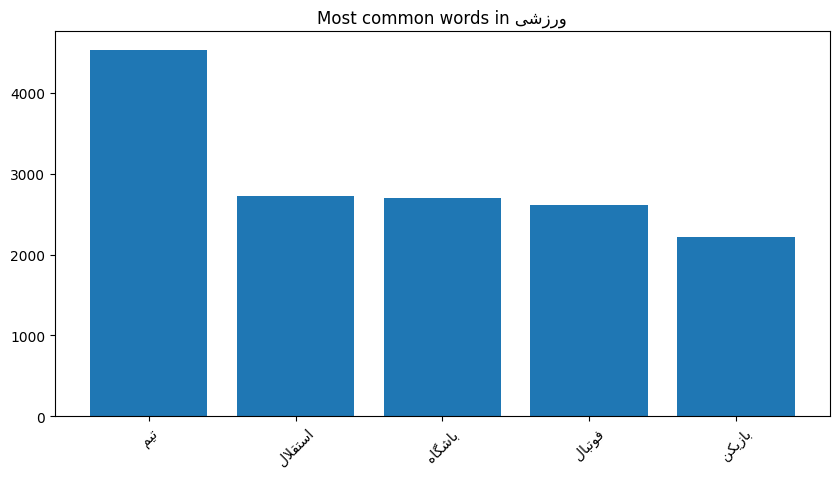

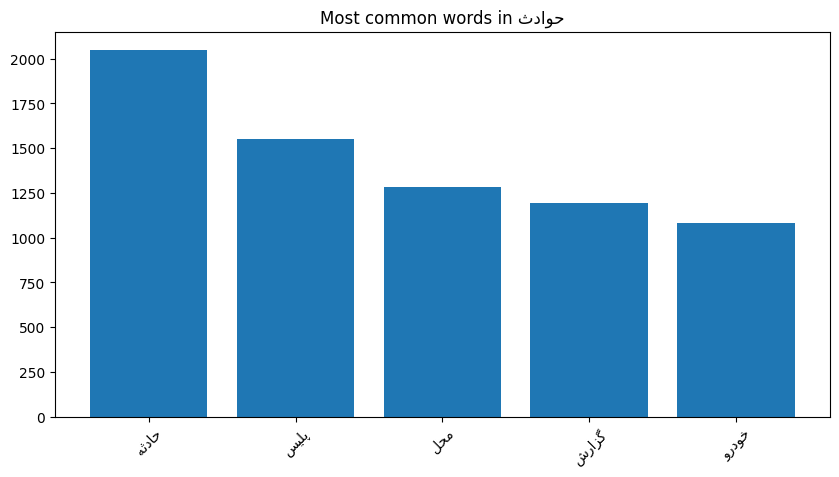

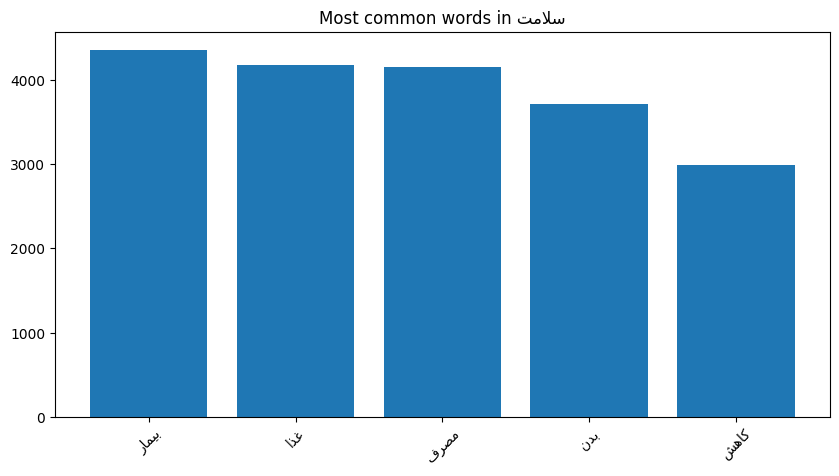

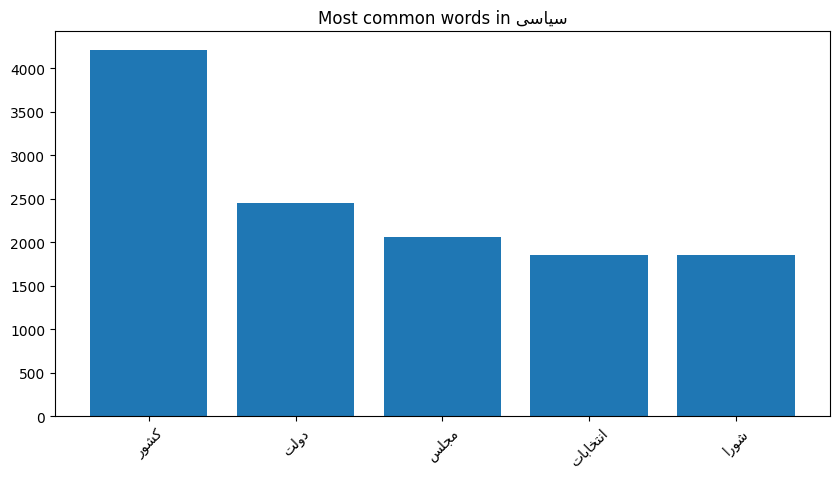

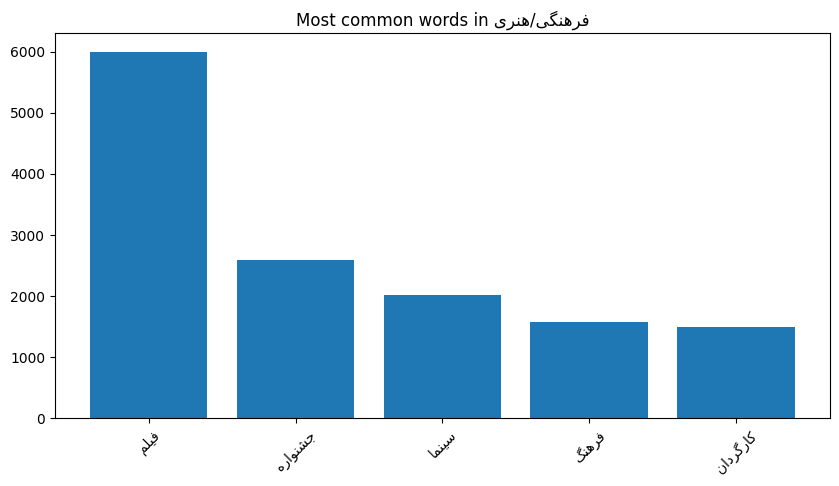

In [11]:
train_df = normalize(train_df)
plot_most_common_words_for_each_label(train_df)

<div dir='rtl'>
<h3>سوالات</h3>
<ol>
    <li>عمل stemming برای حذف بخش‌های اضافی از کلمات به کار می‌رود برای مثال می‌توانیم به کمک انجام این کار، کلمه 
    «کتاب ها»
    را به 
    «کتاب»
    تبدیل کنیم. در اینجا از کتابخانه
    hazm
    استفاده می‌شود. دلیل استفاده از این روش این است که کلمه 
    «کتاب»
    با کلمه
    «کتاب ها»
    فرقی در شناسایی موضوع ایجاد نمی‌کند.<br/>
    روش 
    lemmatization
    برای تبدیل افعال به بن مضارع/ماضی آن‌ها استفاده می‌شود. برای مثال کلمه
    «می روم»
    را به
    «رفت#رو»
    تبدیل می‌کند تا شخص افعال تقاوتی در موضوع ایجاد نکند.
</ol>
</div>